# Looks like we may have a new champion

In [ ]:
import torch
import test
# from configs import Config
from torchvision.transforms import v2
from video_dataset import VideoDataset
import os
from torch.utils.data import DataLoader
# from models.pytorch_r3d import Resnet3D18_basic
from torchvision.models.video import MViT_V2_S_Weights ,mvit_v2_s
import json
import torch.nn.functional as F
import torch.nn as nn

from video_dataset import VideoDataset
from configs import load_config, print_config_old
from train import set_seed
import utils


In [2]:
set_seed(42)

## Experiment details

In [ ]:
exp_no = '001'
split = 'asl100'
model = 'MViT_V2_S'
root = '../data/WLASL/WLASL2000'
labels = f'./preprocessed/labels/{split}'
output = f'runs/{split}/{model}_exp{exp_no}'
save_path = f'{output}/checkpoints'
config_path = f'./configfiles/{split}/{model}_{exp_no}.ini'
arg_dict = {
  'model' : model,
  'exp_no': exp_no,
  'split' : split,
  'root' : root,
  'labels' : labels,
  'save_path' : save_path,
  'config_path' : config_path 
}
config = load_config(arg_dict)
print_config_old(config, title='Testing')



Testing MViT_V2_S on split asl100
              Experiment no: 001
              Raw videos at: ../data/WLASL/WLASL2000
              Labels at: ./preprocessed/labels/asl100
              Saving files to: runs/asl100/MViT_V2_S_exp001/checkpoints
              Config: ./configfiles/asl100/MViT_V2_S_001.ini

TRAINING:
    batch_size      : 4
    update_per_step : 2
    max_steps       : 64000
    max_epoch       : 200

OPTIMIZER:
    lr           : 1e-05
    eps          : 0.001
    weight_decay : 0.0001

SCHEDULER:
    tmax    : 100
    eta_min : 1e-05

DATA:
    num_frames : 16
    frame_size : 224



## Setup test data

In [4]:
mean=[0.45, 0.45, 0.45]
std=[0.225, 0.225, 0.225]
  
mvitv2s_final = v2.Compose([
  v2.Lambda(lambda x: x.float() / 255.0),
  v2.Normalize(mean=mean, std=std),
  v2.Lambda(lambda x: x.permute(1,0,2,3)) 
])

train_transforms = v2.Compose([v2.RandomCrop(config['data']['frame_size']),
                                 v2.RandomHorizontalFlip(),
                                 mvitv2s_final])
test_transforms = v2.Compose([v2.CenterCrop(config['data']['frame_size']),
                                mvitv2s_final])

test_instances = os.path.join(config['admin']['labels'],'test_instances_fixed_frange_bboxes_len.json')
test_classes = os.path.join(config['admin']['labels'], 'test_classes_fixed_frange_bboxes_len.json')

test_set = VideoDataset(config['admin']['root'], test_instances, test_classes,
    transforms=test_transforms, num_frames=config['data']['num_frames'])
test_loader = DataLoader(test_set,
    batch_size=1, shuffle=True, num_workers=2,pin_memory=False, drop_last=False)
num_classes = len(set(test_set.classes))
print(len(test_set))
print(len(test_loader))
print(num_classes)
print(len(set(test_loader.dataset.classes)))

258
258
100
100


## Setup model

In [5]:
fname = 'best.pth'
path = os.path.join(config['admin']['save_path'], fname)
print(path)

runs/asl100/MViT_V2_S_exp001/checkpoints/best.pth


In [6]:
mvitv2s = mvit_v2_s(MViT_V2_S_Weights.KINETICS400_V1)

#does not allow altering num_classes, so need to replace head
original_linear = mvitv2s.head[1]  # The Linear layer
in_features = original_linear.in_features
mvitv2s.head = nn.Sequential(
  nn.Dropout(0.5, inplace=True),
  nn.Linear(in_features, num_classes)
)

checkpoint = torch.load(path, weights_only=True)
mvitv2s.load_state_dict(checkpoint)

/home/luke/miniconda3/envs/wlasl/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


<All keys matched successfully>

## Test it

In [7]:
test.test_top_k(mvitv2s, test_loader, save_dir=config['admin']['save_path'])

Testing: 100%|██████████| 258/258 [00:17<00:00, 14.41it/s]

top-k average per class acc: 0.716, 0.8866666666666666, 0.9416666666666665
Overall top1 (sklearn style) 0.7170542635658915


Damn that is quite a substantial jump

## Plot results

In [8]:
accuracy, class_report, all_preds, all_targets = test.test_model(mvitv2s, test_loader)
print(f'Accuracy score: {accuracy}')

Testing: 100%|██████████| 258/258 [00:17<00:00, 14.91it/s]

Accuracy score: 0.7170542635658915


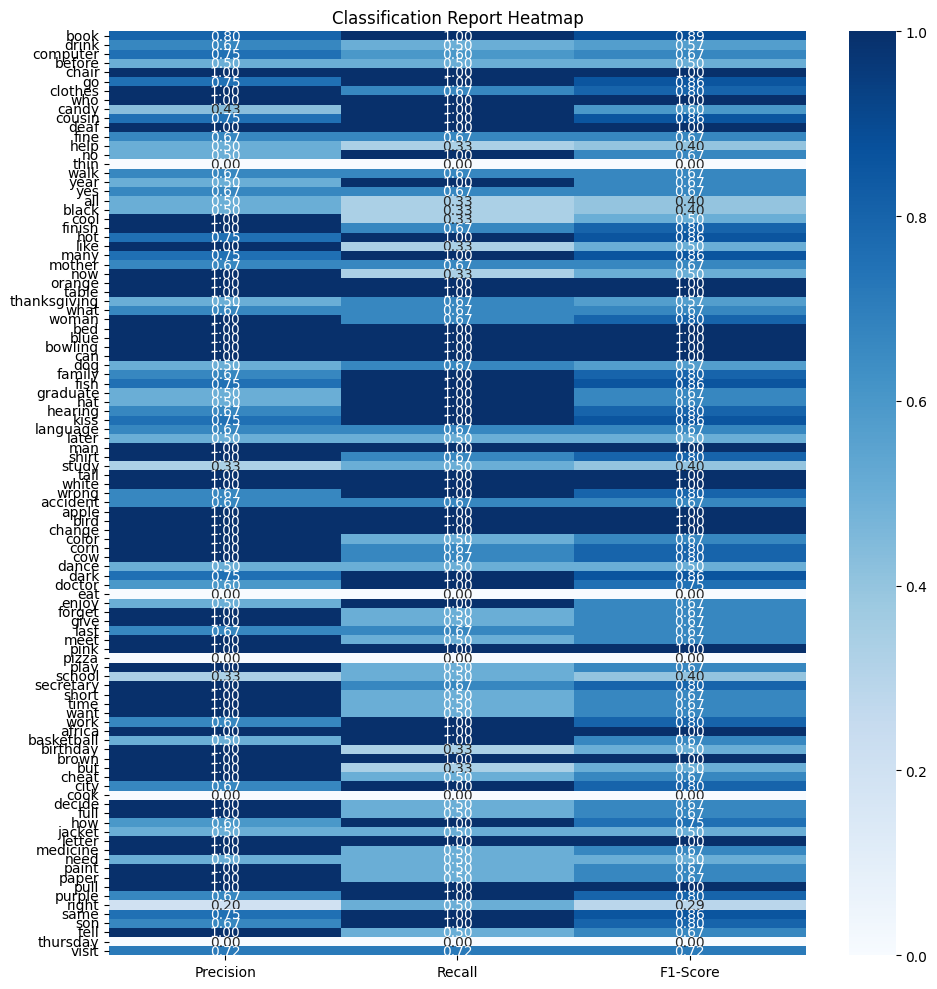

In [9]:
classes_path = './wlasl_class_list.json'
test.plot_heatmap(class_report, classes_path)

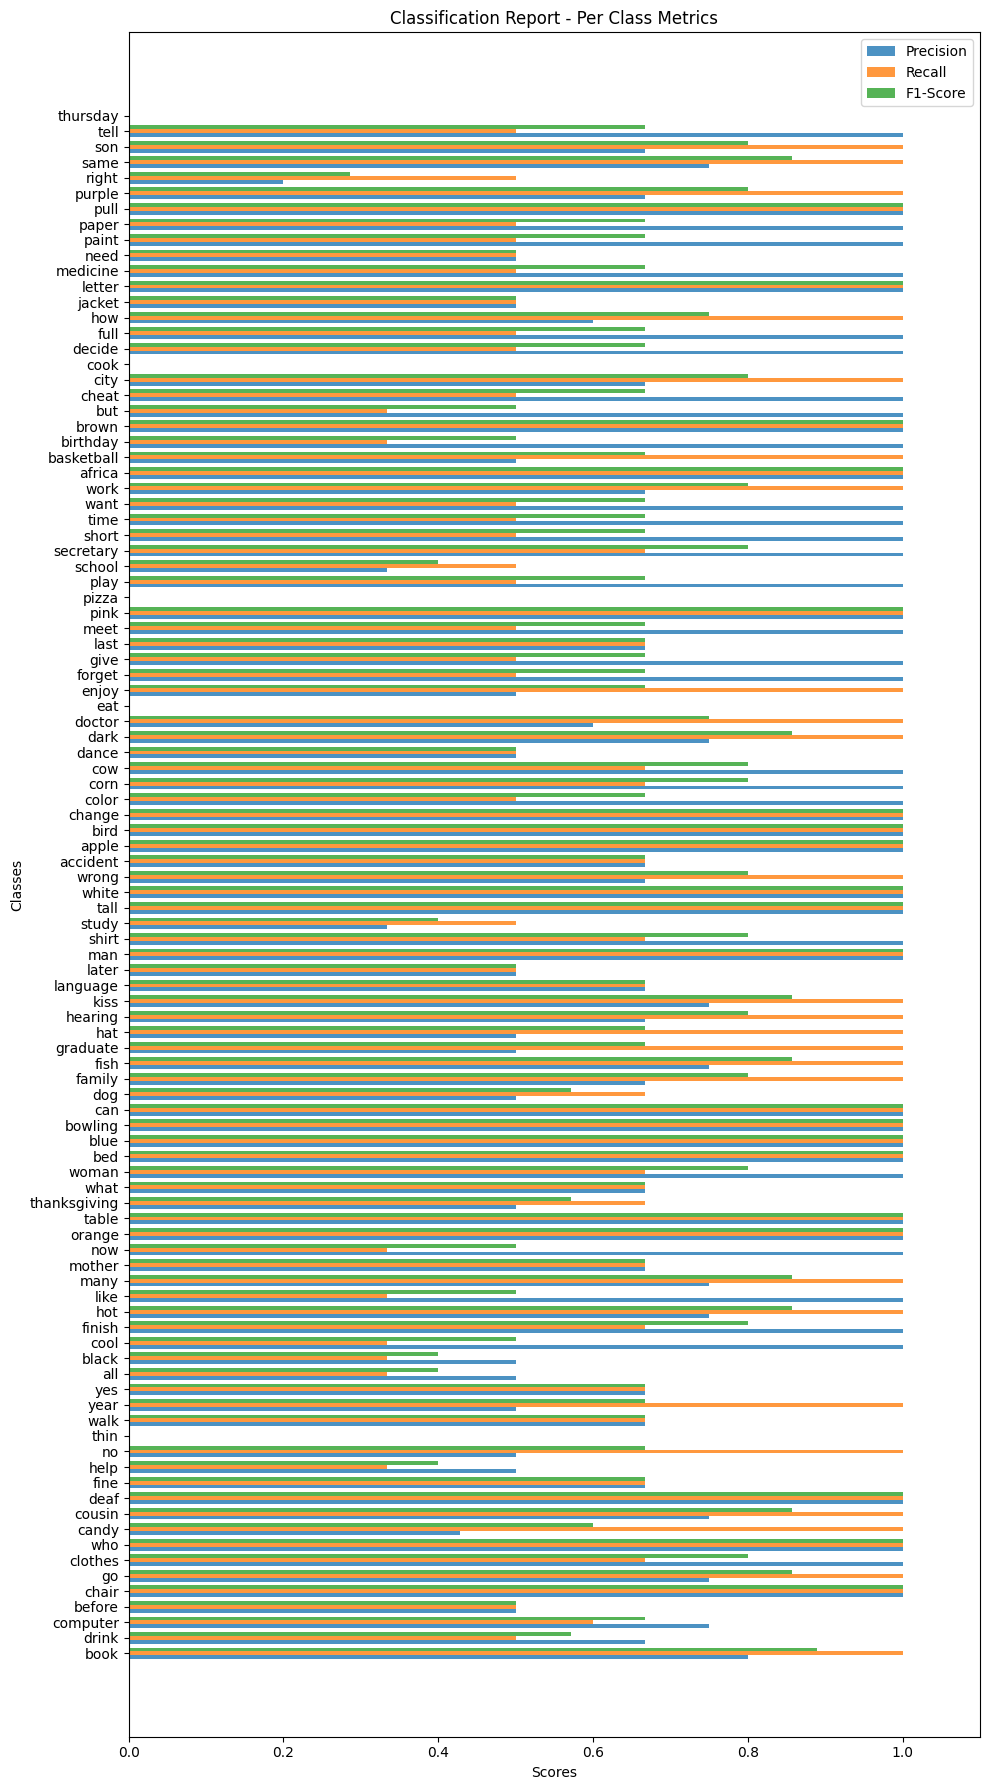

In [10]:
test.plot_bar_graph(class_report, classes_path)

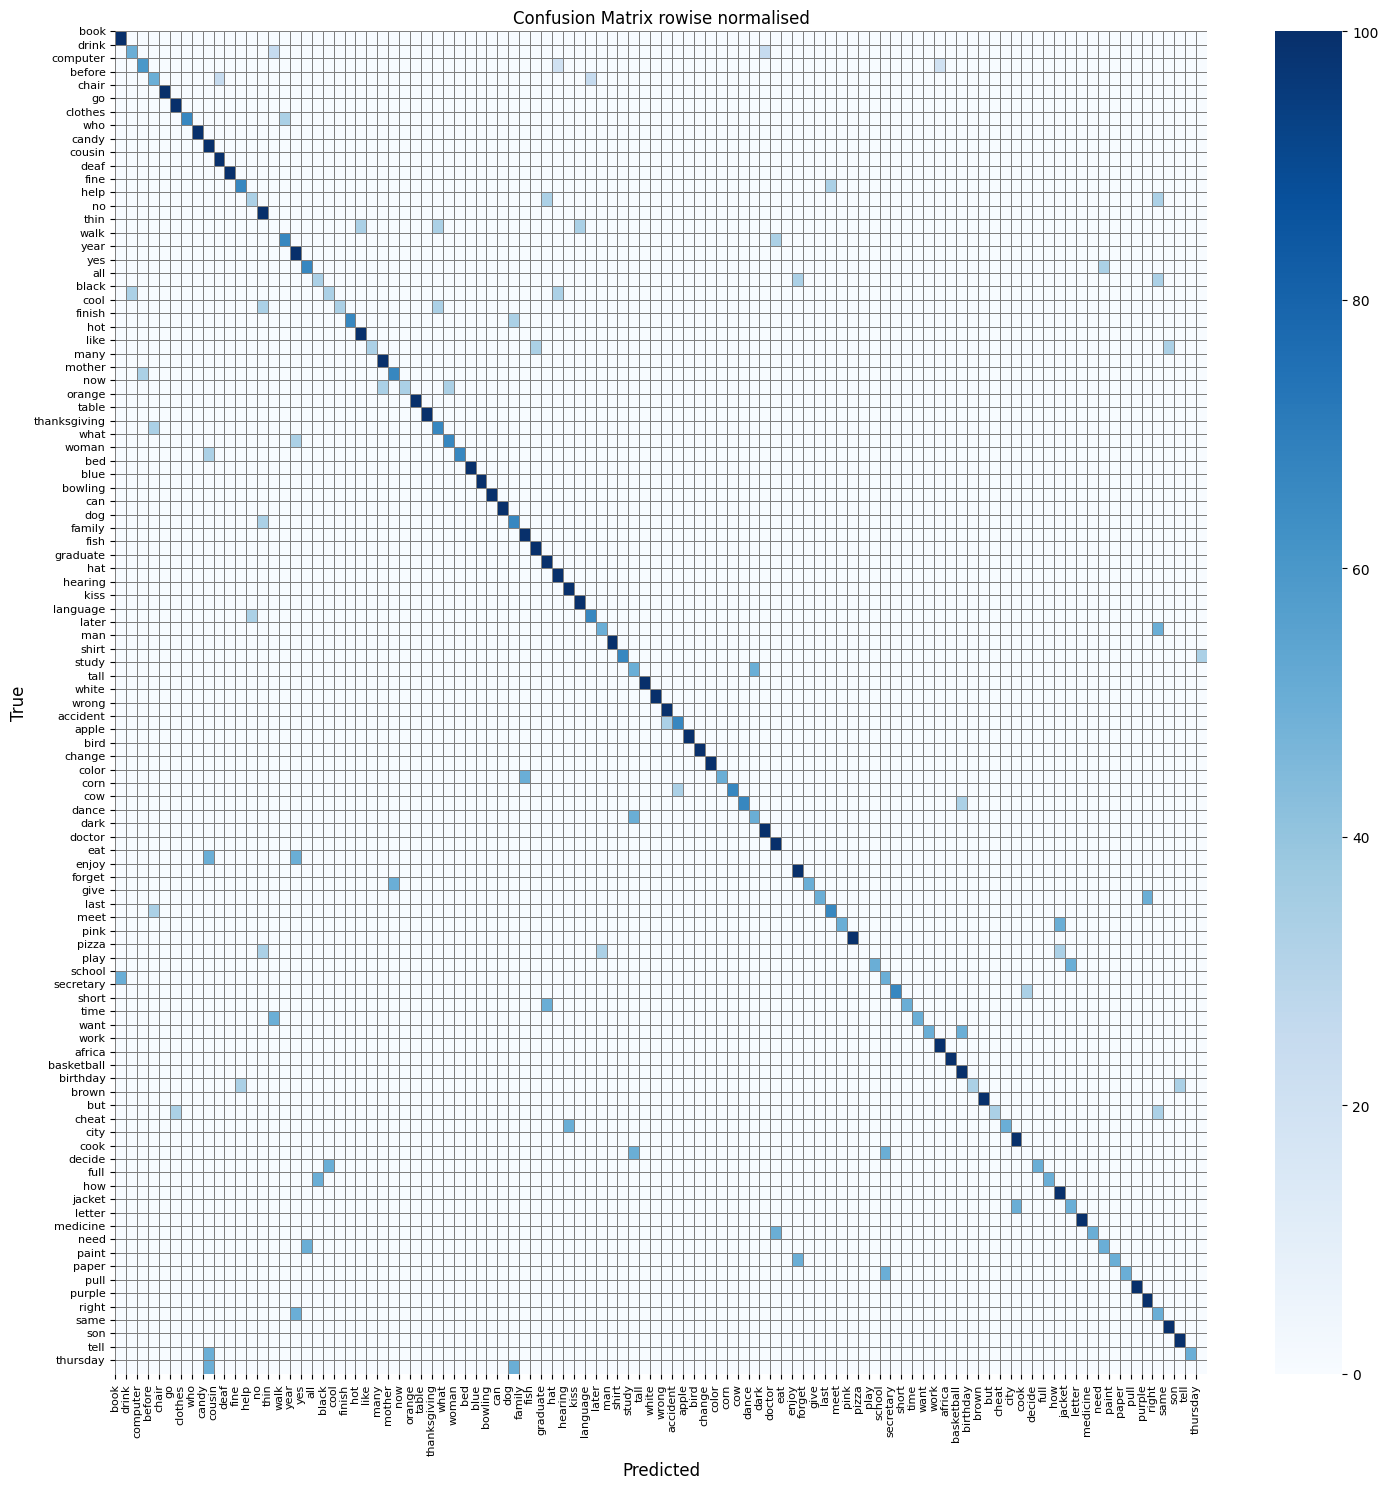

In [11]:
test.plot_confusion_matrix(all_targets, all_preds, classes_path=classes_path, size=(15, 15))

## Still strugles with thursday

In [12]:
def print_dict(dic):
  print("{")
  for key, value in dic.items():
    print(f"'{key}': {value}")
  print("}")  

with open(classes_path, 'r') as f:
  class_list = json.load(f)
print(class_list[99])

thurs1 = test_set.data[256]
thurs2 = test_set.data[257]

print_dict(thurs1)
print_dict(thurs2)


thursday
{
'label_num': 99
'frame_end': 46
'frame_start': 1
'video_id': 58359
'bbox': [51, 41, 212, 222]
}
{
'label_num': 99
'frame_end': 92
'frame_start': 0
'video_id': 70026
'bbox': [61, 30, 199, 235]
}


In [13]:
frames1 = test_set.__manual_load__(thurs1)
frames2 = test_set.__manual_load__(thurs2)
utils.watch_video(frames1)
utils.watch_video(frames2)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
results = []
y_true_all = []
y_pred_all = []
thurs1 = test_set.__getitem__(256)
thurs2 = test_set.__getitem__(257)

frames1 = thurs1['frames']
frames2 = thurs2['frames']
frames1, frames2 = frames1.to(device), frames2.to(device)
with torch.no_grad():
  out = mvitv2s(frames1.unsqueeze(0))
  out1 = mvitv2s(frames2.unsqueeze(0))
  
  pred_class = torch.argmax(out, dim=1)
  pred_class1 = torch.argmax(out, dim=1)
  
  # model_predictions.extend([pred_class.cpu().numpy(), pred_class1.cpu().numpy()])
  
  if len(y_true_all) == 0: #do this once
    y_true_all.extend([thurs1['label_num'], thurs2['label_num']])
    
  probs = F.softmax(out, dim=1)
  probs1 = F.softmax(out1, dim=1)
  
  print(f"Item thurs1 - True class: {class_list[thurs1['label_num']]}, Predicted: {class_list[pred_class.item()]}")
  print(f"Item thurs2 - True class: {class_list[thurs2['label_num']]}, Predicted: {class_list[pred_class1.item()]}")

  # Get confidence
  confidence = torch.max(probs, dim=1)[0]
  confidence1 = torch.max(probs1, dim=1)[0]

  print(f"Item 256 confidence: {confidence.item():.3f}")
  print(f"Item 257 confidence: {confidence1.item():.3f}")
  print()
  print('-'*10)
  print()

cuda
Item thurs1 - True class: thursday, Predicted: dog
Item thurs2 - True class: thursday, Predicted: dog
Item 256 confidence: 0.684
Item 257 confidence: 0.510

----------



## resnet3d18 models also predicted dog

In [17]:
dog_idxs = [i for i, x in enumerate(test_set.classes) if x == 'dog']
print(dog_idxs)

[109, 110, 111]


In [18]:
titems = [test_set.data[i] for i in dog_idxs]
for itm in titems:
  tframes = test_set.__manual_load__(itm)
  utils.watch_video(tframes, title='Dog')